+ 通过前面实现的DDP我们可以知道，数据并行之所以能够加速训练，是因为它能够提高每一个epoch训练的batch_size，并且使用ring allreduce缓解了传统PS-worker模式下的通信问题，但是，DDP会在每张卡上都保留一个模型的副本，仍然不能解决当模型过大使得一张卡放不下的问题，因此提出模型并行，将一份大模型按照不同的layer切分(shard)到不同的卡上，实现很简单，加载huggingface上面的模型时，会自动按照GPUs > CPU > Disk的优先级进行划分

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
model = LlamaForCausalLM.from_pretrained("decanlp/llama-7b-hf", device_map="auto", load_in_8bit=True)

# 受限于学校局域网没有代理无法连接，大概效果就是会将模型参数平分到每张GPU上，即使模型能够放在一张GPU上也会分到多张GPU上
print(model.hf_device_map)

+ 下面实现一个ResNet50的模型分割

In [6]:
import torch
from torch import nn
from torchvision.models.resnet import ResNet, Bottleneck
from torchsummary import summary

In [ ]:
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=1000).to("cuda:0")
summary(model, (3, 128, 128), device="cuda")

In [9]:
class ModelParallelResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(block=Bottleneck, layers=[3, 4, 6, 3], num_classes=num_classes)
        # shard the model across GPUs
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1,
            self.layer2,
        ).to("cuda:0")
        
        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to("cuda:1")
        
        self.fc.to("cuda:1")
    
    def forward(self, x):
        x = self.seq1(x).to("cuda:1")
        x = self.seq2(x)
        return self.fc(x.view(x.size(0), -1))

In [10]:
model = ModelParallelResNet50()

In [15]:
num_classes = 1000
num_epoch = 3
batch_size = 32
img_size = (128, 128)

def generate_random_data():
    inputs = torch.randn(batch_size, 3, img_size[0], img_size[1])
    one_hot_indices = torch.LongTensor(batch_size).random_(0, num_classes).view(batch_size, 1)
    one_hot = torch.zeros(batch_size, num_classes).scatter_(1, one_hot_indices, 1)
    return inputs, one_hot

def train(model):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for _ in range(num_epoch):
        inputs, labels = generate_random_data()
        optimizer.zero_grad()
        outputs = model(inputs.to("cuda:0"))
        loss = loss_fn(outputs, labels.to(outputs.device))
        loss.backward()
        optimizer.step()

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

# 模型并行
setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

# 单卡
setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()

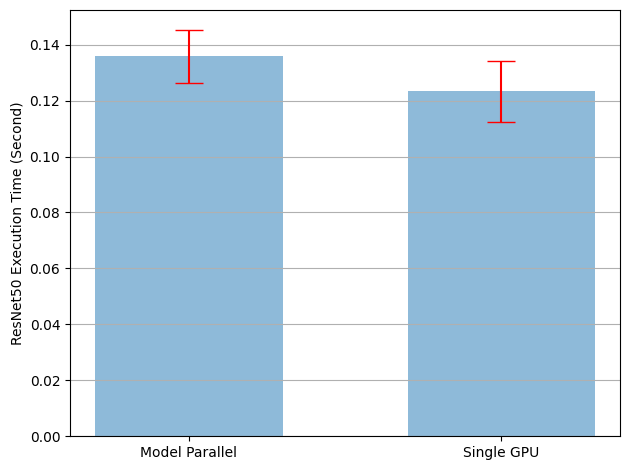

In [ ]:
plot(
    [mp_mean, rn_mean],
    [mp_std, rn_std],
    ['Model Parallel', 'Single GPU'],
    'model_parallel.png'
)
# 对比可以看出模型并行的速度比单卡慢了很多，主要是因为数据需要在两张GPU之间传输